In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from hyperopt import hp, fmin, rand
import collections
import statsmodels.api as sm

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [42]:
df = pd.read_csv("Kiev.csv")
df = df.drop(columns=["id"])
df.reviews_per_month = df.reviews_per_month.str.replace(',','.',regex=True)
df.reviews_per_month = pd.to_numeric(df["reviews_per_month"])

df

,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Entire home/apt,40,2,111,9.25,106,365
1,Entire home/apt,23,2,64,5.33,6,170
2,Entire home/apt,24,2,13,1.08,22,31
3,Entire home/apt,24,1,130,10.83,8,15
4,Entire home/apt,32,3,108,9.00,30,258
...,...,...,...,...,...,...,...
165,Entire home/apt,32,1,67,5.58,47,54
166,Entire home/apt,54,2,31,2.58,14,114
167,Entire home/apt,62,1,0,0.00,2,54
168,Entire home/apt,40,2,0,0.00,1,365


In [43]:
#df = df.drop(columns=['neighbourhood'])
#df = df.drop(columns=['city'])
#df = df.drop(columns=['last_review'])
#df = df[df["room_type"]=="Entire home/apt"]
#df = df.drop(columns=['room_type'])

df

,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Entire home/apt,40,2,111,9.25,106,365
1,Entire home/apt,23,2,64,5.33,6,170
2,Entire home/apt,24,2,13,1.08,22,31
3,Entire home/apt,24,1,130,10.83,8,15
4,Entire home/apt,32,3,108,9.00,30,258
...,...,...,...,...,...,...,...
165,Entire home/apt,32,1,67,5.58,47,54
166,Entire home/apt,54,2,31,2.58,14,114
167,Entire home/apt,62,1,0,0.00,2,54
168,Entire home/apt,40,2,0,0.00,1,365


In [44]:
df.dtypes
#df

room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

<AxesSubplot:>

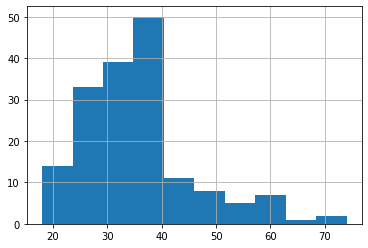

In [45]:
df.price.hist()

<AxesSubplot:>

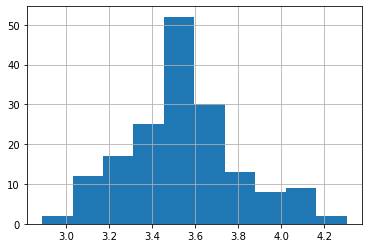

In [46]:
np.log(df.price).hist()

<AxesSubplot:>

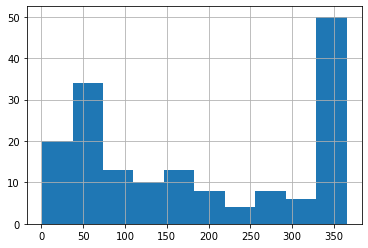

In [7]:
df.availability_365.hist()

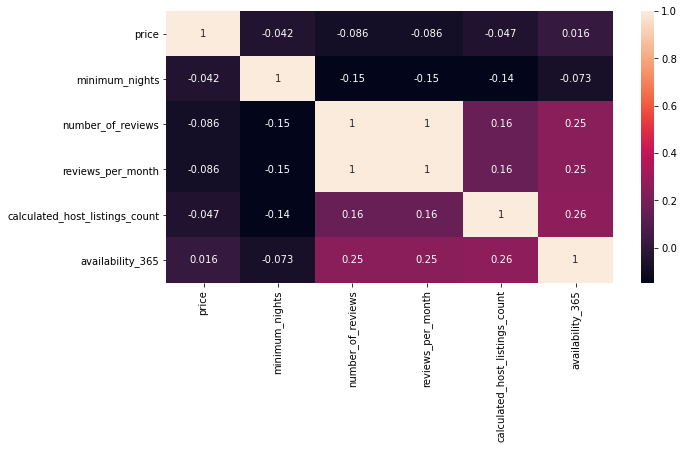

In [8]:
corrmat = df[df._get_numeric_data().columns].corr().round(7)
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(corrmat, annot=True)
plt.show()

In [47]:
df.price=np.log(df.price)

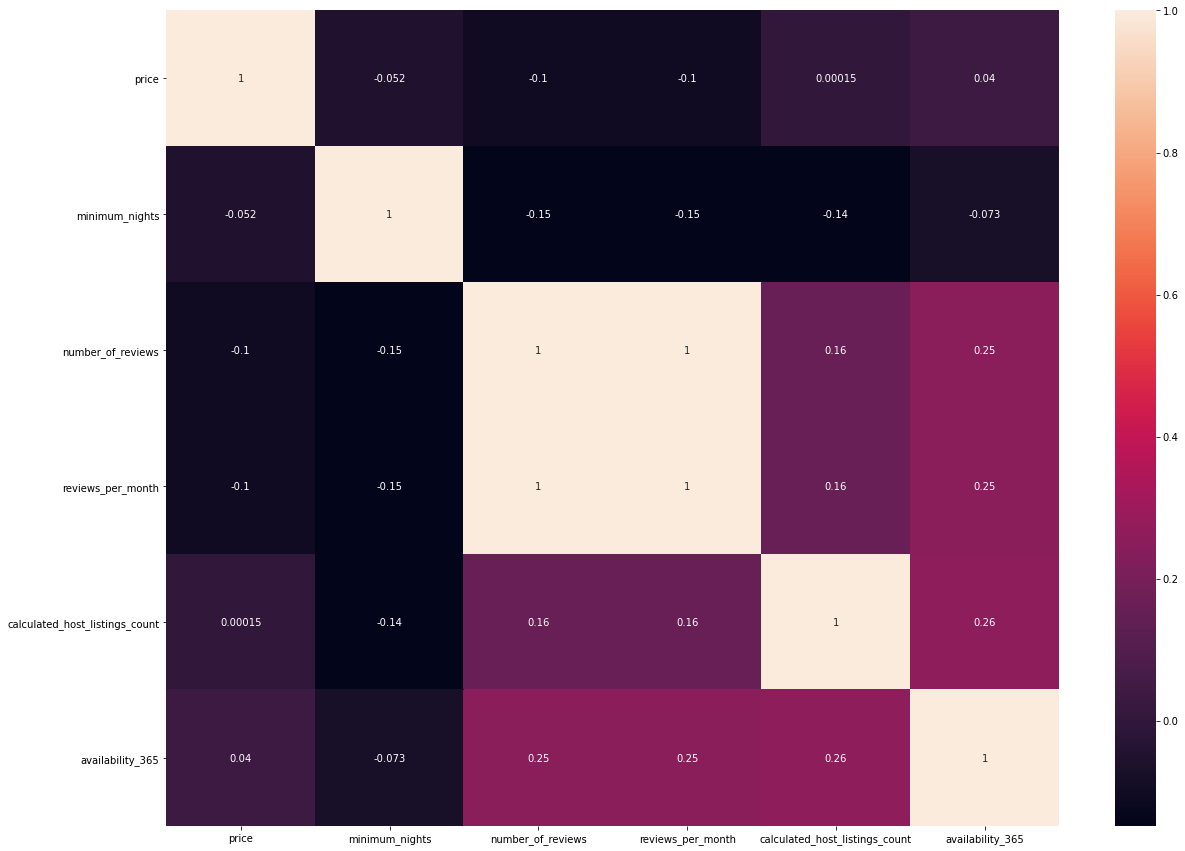

In [10]:
corrmat = df[df._get_numeric_data().columns].corr().round(7)
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, annot=True)
plt.show()

In [48]:
def encoding_char(df):
    char_var = list(set(df.columns) - set(df._get_numeric_data().columns))
    for col_names in char_var:
        f = pd.factorize(df[col_names])
        df[col_names] = pd.factorize(df[col_names])[0]
    return(df)

df = encoding_char(df)
df.head()

,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,0,3.688879,2,111,9.25,106,365
1,0,3.135494,2,64,5.33,6,170
2,0,3.178054,2,13,1.08,22,31
3,0,3.178054,1,130,10.83,8,15
4,0,3.465736,3,108,9.00,30,258


In [49]:
train, test = train_test_split(df, test_size=0.2, random_state=0)
X_train = train.drop('price', axis=1)
X_test = test.drop('price', axis=1)
y_train = train.price
y_test = test.price

In [57]:
def metrics(X_train, X_test, y_train, y_test, y_pred, model):
    MSE = [mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train))), mean_squared_error(np.exp(y_test), np.exp(y_pred))]
    RMSE = [np.sqrt(mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train)))),np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))]
    R2 = [model.score(X_train, np.exp(y_train)), model.score(X_test, np.exp(y_test))]
    results = {'MSE': MSE, 'RMSE': RMSE, 'R2':R2}
    return pd.DataFrame(results, index=['Train', 'Test'])

def visualising(X_train, X_test, y_train, y_test, y_pred, model):
    ### Training set ### 
    plt.scatter(X_train[['reviews_per_month']], np.exp(y_train), color = 'red')
    plt.plot(X_train[['reviews_per_month']], np.exp(model.predict(X_train)), 'bo')
    plt.title('Price vs Reviews per month (Training set) Kiev')
    plt.xlabel('Reviews per month')
    plt.ylabel('Price')
    plt.show()
    
    ### Test set ### 
    plt.scatter(X_test[['reviews_per_month']], np.exp(y_test), color = 'red')
    plt.plot(X_test[['reviews_per_month']], np.exp(y_pred), 'bo')
    plt.title('Price vs Reviews per month (Test set) Kiev')
    plt.xlabel('Reviews per month')
    plt.ylabel('Price')
    plt.show()


In [52]:
mr = LinearRegression().fit(X_train, y_train)
mr.coef_, mr.intercept_

(array([ 6.96815443e-02, -1.12316432e-02,  7.60651445e-02, -9.18680966e-01,
         1.12647134e-04, -3.31330763e-06]),
 3.5892543949134703)

In [54]:
mr_y_pred = mr.predict(X_test)
metric_lr = metrics(X_train, X_test, y_train, y_test, mr_y_pred, mr).round(2)
metric_lr["Type"] = "Linear regression"
metric_lr["city"] = "Kiev"
metric_lr
metrics(X_train, X_test, y_train, y_test, mr_y_pred, mr).round(2)

,MSE,RMSE,R2
Train,104.66,10.23,-10.11
Test,87.17,9.34,-10.92


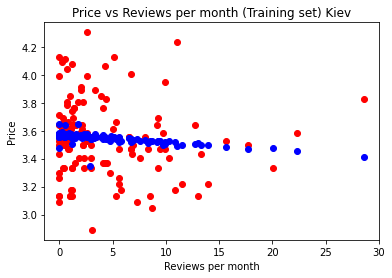

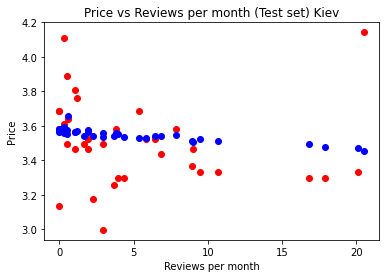

In [56]:
visualising(X_train, X_test, y_train, y_test, mr_y_pred, mr)

In [18]:
X = sm.add_constant(X_train)
mr1 = sm.OLS(y_train, X).fit()
#mr1.pvalues
mr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.2971
Date:                Sun, 14 Feb 2021   Prob (F-statistic):              0.914
Time:                        13:59:45   Log-Likelihood:                -9.6744
No. Observations:                 132   AIC:                             31.35
Df Residuals:                     126   BIC:                             48.65
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              3.5534      0.054     66.406      0.000       3.447       3.659
minimum_nights                    -0.0085      0.012     -0.697      0.487      -0.033       0.016
number_of_reviews                 -0.0550      0.784     -0.070      0.944      -1.606       1.497
reviews_per_month                  0.6562      9.409      0.070      0.945     -17.963      19.276
calculated_host_listings_count    -0.0003      0.001     -0.470      0.639      -0.002       0.001
availability_365                   0.0001      0.000      0.703      0.484      -0.000       0.000
==============================================================================
Omnibus:                        6.655   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                6.214
Skew:                           0.474   Prob(JB):                       0.0447
Kurtosis:                       3.480   Cond. No.                     1.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
X_train_opt = X_train.drop(columns=["number_of_reviews", "calculated_host_listings_count","reviews_per_month"])
X_test_opt = X_test.drop(columns=["number_of_reviews", "calculated_host_listings_count","reviews_per_month"])
X_train_opt

,minimum_nights,availability_365
108,1,365
24,1,365
154,1,280
155,1,214
19,2,189
...,...,...
9,3,91
104,1,365
68,2,70
118,4,339


In [20]:
mr = LinearRegression().fit(X_train_opt, y_train)
mr.coef_, mr.intercept_

(array([-6.43547324e-03,  7.51785685e-05]), 3.532892667623979)

In [21]:
mr_y_pred = mr.predict(X_test_opt)
metrics(X_train_opt, X_test_opt, y_train, y_test, mr_y_pred, mr).round(2)

,MSE,RMSE,R2
Train,103.23,10.16,0.0
Test,112.13,10.59,0.0


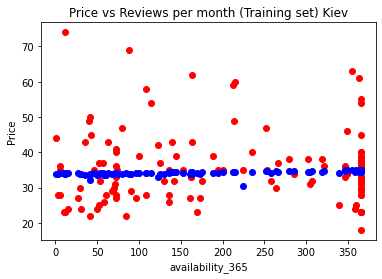

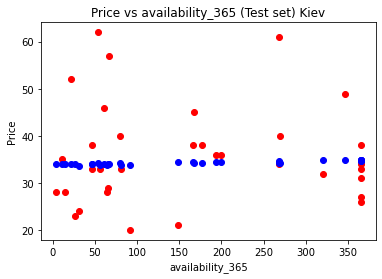

In [22]:

def visualising_opt(X_train, X_test, y_train, y_test, y_pred, model):
    ### Training set ### 
    plt.scatter(X_train[['availability_365']], np.exp(y_train), color = 'red')
    plt.plot(X_train[['availability_365']], np.exp(model.predict(X_train)), 'bo')
    plt.title('Price vs Reviews per month (Training set) Kiev')
    plt.xlabel('availability_365')
    plt.ylabel('Price')
    plt.show()
    
    ### Test set ### 
    plt.scatter(X_test[['availability_365']], np.exp(y_test), color = 'red')
    plt.plot(X_test[['availability_365']], np.exp(y_pred), 'bo')
    plt.title('Price vs availability_365 (Test set) Kiev')
    plt.xlabel('availability_365')
    plt.ylabel('Price')
    plt.show()
    
    
visualising_opt(X_train_opt, X_test_opt, y_train, y_test, mr_y_pred, mr)

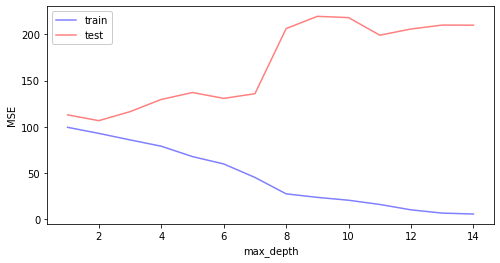

In [23]:
def max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = DecisionTreeRegressor(max_depth = i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [24]:
dt = DecisionTreeRegressor(max_depth = 2, random_state=10).fit(X_train, y_train)
dt_y_pred = dt.predict(X_test)
metrics(X_train, X_test, y_train, y_test, dt_y_pred, dt).round(2).abs()
metric_dt = metrics(X_train, X_test, y_train,y_test, dt_y_pred, dt).round(2).abs()
metric_dt["Type"] = "Decision tree"
metric_dt["city"] = "Kiev"
metric_dt

,MSE,RMSE,R2,Type,city
Train,92.95,9.64,0.09,Decision tree,Kiev
Test,106.74,10.33,0.05,Decision tree,Kiev


In [39]:
dt.tree_

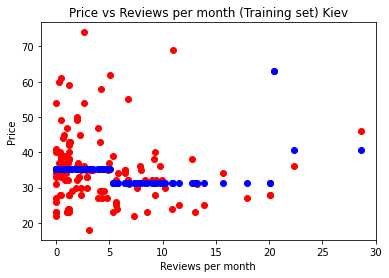

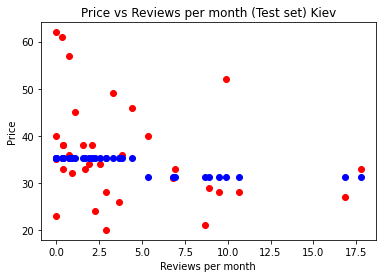

In [25]:
visualising(X_train, X_test, y_train, y_test, dt_y_pred, dt)

Text(0.5, 1.0, 'Decision Tree. Feature Importance. Kiev')

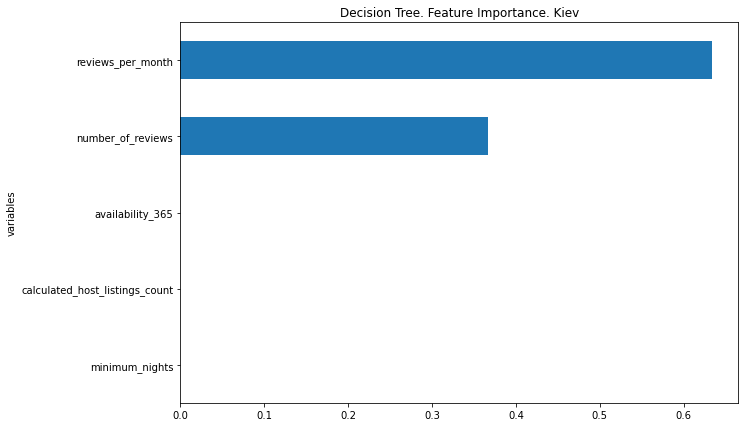

In [116]:
dt_imp = pd.DataFrame({'imp': dt.feature_importances_, 'variables': X_train.columns})
dt_imp = dt_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
dt_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
plt.title('Decision Tree. Feature Importance. Kiev')

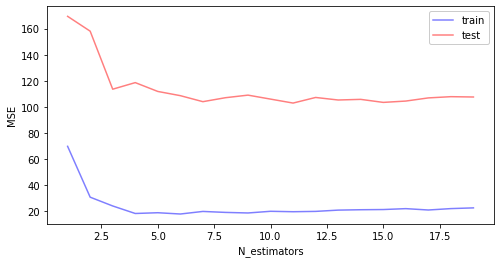

In [118]:
def rf_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    ax.legend(framealpha=1, frameon=True);

    
rf_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,20)))

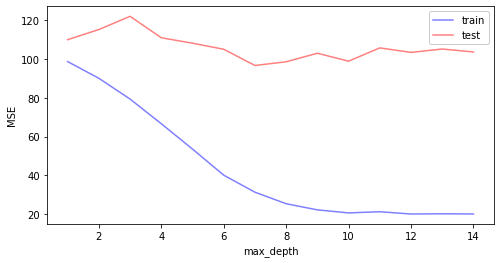

In [119]:
def rf_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=7, max_depth =i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
rf_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [26]:
rf = RandomForestRegressor(n_estimators = 7, max_depth = 3, random_state = 10).fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
metrics(X_train, X_test, y_train, y_test, rf_y_pred, rf).round(2).abs()
metric_rf = metrics(X_train, X_test, y_train,y_test,  rf_y_pred, rf).round(2).abs()
metric_rf["Type"] = "Random forest"
metric_rf["city"] = "Kiev"
metric_rf

,MSE,RMSE,R2,Type,city
Train,79.39,8.91,0.25,Random forest,Kiev
Test,122.12,11.05,0.12,Random forest,Kiev


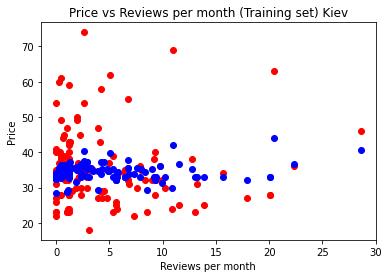

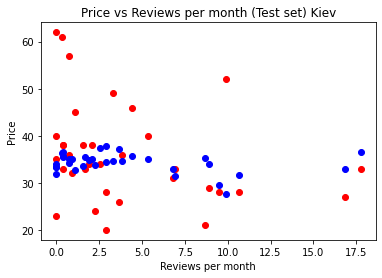

In [27]:
visualising(X_train, X_test, y_train, y_test, rf_y_pred, rf)

Text(0.5, 1.0, 'Random Forest. Feature Importance. Kiev')

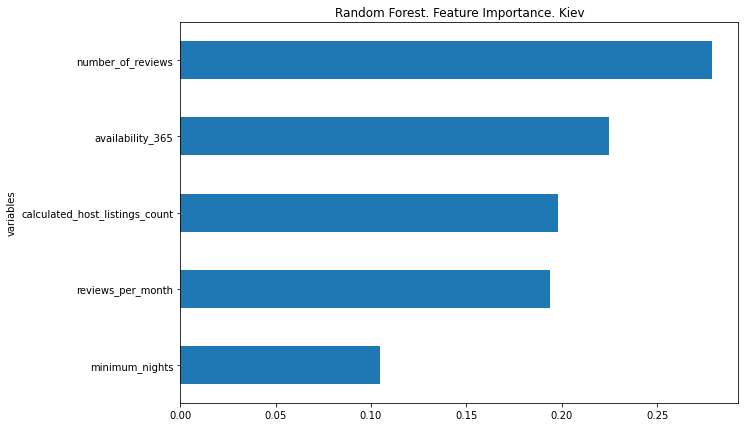

In [122]:
rf_imp = pd.DataFrame({'imp': rf.feature_importances_, 'variables': X_train.columns})
rf_imp = rf_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
rf_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
plt.title('Random Forest. Feature Importance. Kiev')

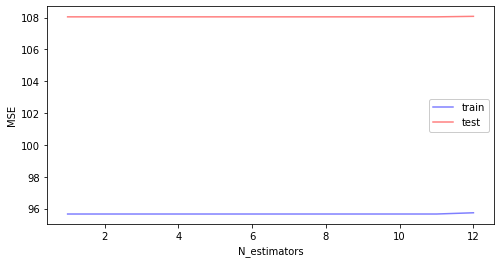

In [125]:
def catboost_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=i, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(catboost.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(catboost.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    ax.legend(framealpha=1, frameon=True);

    
catboost_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,13)))



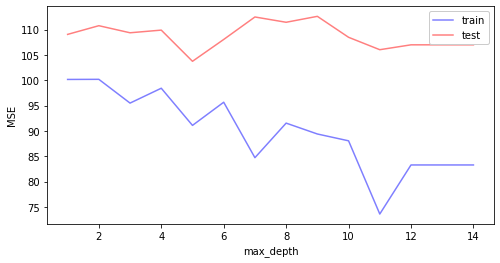

In [126]:
def catboost_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=2, max_depth=i, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(catboost.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(catboost.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
catboost_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [29]:
catboost = CatBoostRegressor(iterations=2, max_depth=5, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
cat_y_pred = catboost.predict(X_test)
metrics(X_train, X_test, y_train, y_test, cat_y_pred, catboost).round(2)

,MSE,RMSE,R2
Train,91.09,9.54,0.13
Test,103.74,10.19,0.10


In [30]:
metric_cb = metrics(X_train, X_test, y_train,y_test, cat_y_pred, catboost).round(2)
metric_cb["Type"] = "Catboost"
metric_cb["city"] = "Kiev"
metric_cb

,MSE,RMSE,R2,Type,city
Train,91.09,9.54,0.13,Catboost,Kiev
Test,103.74,10.19,0.10,Catboost,Kiev


In [145]:
metric=pd.concat([metric_lr,metric_dt,metric_rf,metric_cb])
metric

,MSE,RMSE,R2,Type,city
Train,102.45,10.12,0.01,Linear regression,Kiev
Test,109.78,10.48,0.02,Linear regression,Kiev
Train,92.95,9.64,0.09,Decision tree,Kiev
Test,106.74,10.33,0.05,Decision tree,Kiev
Train,79.39,8.91,0.25,Random forest,Kiev
Test,122.12,11.05,0.12,Random forest,Kiev
Train,91.09,9.54,0.13,Catboost,Kiev
Test,103.74,10.19,0.10,Catboost,Kiev


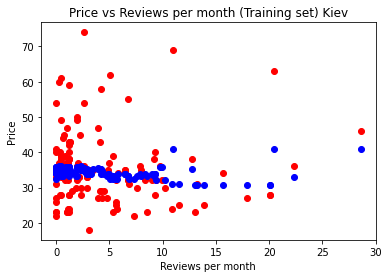

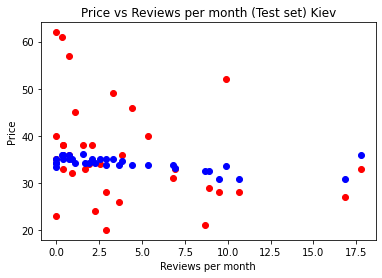

In [128]:
visualising(X_train, X_test, y_train, y_test, cat_y_pred, catboost)

Text(0.5, 1.0, 'Boosting. Feature Importance. Kiev')

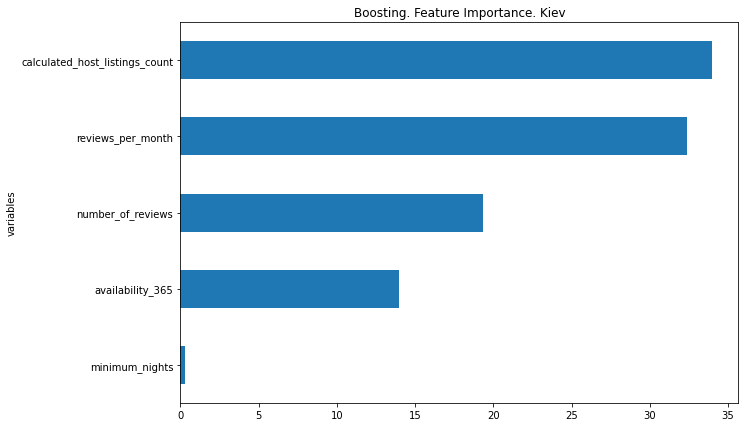

In [129]:
cb_imp = pd.DataFrame({'imp': catboost.get_feature_importance(), 'variables': X_train.columns})
cb_imp = cb_imp.sort_values(['imp', 'variables'], ascending=[True, False]).iloc[-30:]
cb_imp.plot(kind='barh', x='variables', y='imp', figsize=(10, 7), legend=None)
plt.title('Boosting. Feature Importance. Kiev')

In [150]:
metric_Kiev=pd.concat([metric_lr,metric_dt,metric_rf,metric_cb])
metric_Kiev.to_csv("Metric_Kiev.csv", index=True)
metric_DC = pd.read_csv("Metric_DC.csv")
metric_Madrid = pd.read_csv("Metric_Madrid.csv")

In [151]:
metric_Kiev = pd.read_csv("Metric_Kiev.csv")
metric_DC = pd.read_csv("Metric_DC.csv")
metric_Madrid = pd.read_csv("Metric_Madrid.csv")

In [154]:
metric=pd.concat([metric_Kiev,metric_DC,metric_Madrid])
metric.columns = ['Subset', 'MSE', 'RMSE', 'R2', 'Type', 'city']
metric

,Subset,MSE,RMSE,R2,Type,city
0,Train,102.45,10.12,0.01,Linear regression,Kiev
1,Test,109.78,10.48,0.02,Linear regression,Kiev
2,Train,92.95,9.64,0.09,Decision tree,Kiev
3,Test,106.74,10.33,0.05,Decision tree,Kiev
4,Train,79.39,8.91,0.25,Random forest,Kiev
5,Test,122.12,11.05,0.12,Random forest,Kiev
6,Train,91.09,9.54,0.13,Catboost,Kiev
7,Test,103.74,10.19,0.10,Catboost,Kiev
0,Train,4784.76,69.17,0.13,Linear regression,"Washington, D.C."
1,Test,4777.81,69.12,0.17,Linear regression,"Washington, D.C."


In [156]:
metric.columns

Index(['Subset', 'MSE', 'RMSE', 'R2', 'Type', 'city'], dtype='object')

In [163]:
metric.groupby(['city','Subset'])
pd.pivot_table(metric, index=['city', 'Subset','Type'],
                     aggfunc=np.sum)

MSE    R2   RMSE
city             Subset Type                                   
Kiev             Test   Catboost            103.74  0.10  10.19
                        Decision tree       106.74  0.05  10.33
                        Linear regression   109.78  0.02  10.48
                        Random forest       122.12  0.12  11.05
                 Train  Catboost             91.09  0.13   9.54
                        Decision tree        92.95  0.09   9.64
                        Linear regression   102.45  0.01  10.12
                        Random forest        79.39  0.25   8.91
Madrid           Test   Catboost            718.69  0.58  26.81
                        Decision tree       765.33  0.55  27.66
                        Linear regression   810.84  0.46  28.48
                        Random forest       739.23  0.57  27.19
                 Train  Catboost            744.88  0.61  27.29
                        Decision tree       774.50  0.58  27.83
                        Linear regression   947.77  0.40  30.79
                        Random forest       735.17  0.61  27.11
Washington, D.C. Test   Catboost           4252.93  0.28  65.21
                        Decision tree      4301.46  0.28  65.59
                        Linear regression  4777.81  0.17  69.12
                        Random forest      4442.93  0.26  66.66
                 Train  Catboost           4210.78  0.28  64.89
                        Decision tree      4296.16  0.27  65.55
                        Linear regression  4784.76  0.13  69.17
                        Random forest      4429.81  0.24  66.56